In [1]:
import numpy as np
from tqdm import tqdm

In [2]:
import yfinance as yf
# List of yfinance-compatible tickers
tickers = [
    "^GSPC",    # S&P 500 Index
      # iShares U.S. Real Estate ETF (Morgan Stanley REIT Index)
]

# Download monthly returns data for the last 14 years
start_date = "2003-03-01"
end_date = "2016-04-01"

# Fetch monthly data for each ticker
for ticker in tickers:
    data = yf.download(ticker, start=start_date, end=end_date, interval='1mo', progress=False)['Adj Close']
    returns = data.pct_change().dropna() * 100  # Calculate monthly returns


### Define Distribution Functions

In [3]:
def N(mean, variance, size = None):
    return np.random.normal(mean, np.sqrt(variance), size)

def U(start_point, end_point, size = None):
    return np.random.uniform(start_point, end_point, size)

def B(α, β, size = None):
    return np.random.beta(α, β, size)

### Define Observation Functions

In [4]:
def calculate_σ_μ(Y, β):
    μ̄ = np.zeros(len(Y))
    μ̄[0] = Y[0]
    for i in range(1, len(Y)):
        μ̄[i] = β * Y[i] + (1 - β) * μ̄[i - 1]
    return np.std(μ̄)

In [5]:
def x_transition_function(x̄, ϕ_x, σ_x, ξ_t, x_t):
    particles = x̄ + ϕ_x * (x_t - x̄) + σ_x * ξ_t
    return particles

In [6]:
def μ_transition_function(y_t, ϕ_μ, σ_μ, η_μ, μ_t):
    # particles = y_t + ϕ_μ * (μ_t - y_t) + σ_μ * η_μ
    particles = y_t + ϕ_μ * (μ_t - y_t)
    return particles

In [7]:
def observation_function(μ_t, x_t, ϵ_t):
    y_t = μ_t + np.exp(x_t / 2) * ϵ_t
    return y_t

In [8]:
def observation_likelihood(y, μ, x):
    σ_t = np.exp(x / 2)

    likelihood = (1 / (np.sqrt(2 * np.pi) * σ_t)) * np.exp(- ((y - μ)**2) / (2 * σ_t**2))

    return likelihood

In [9]:
observation = Y = returns.values
Y_train = Y[:48]

In [10]:
L = 10_000 # number of particles
T = len(Y) # number of time steps
β = 0.2

In [11]:
α_parameter = np.full(L, np.mean(Y[:24])) # mean of first 2 year return
x̄ = U(-1, 5, L) # shape (L, 1)
ϕ_μ =  np.full(L, 1 - β)# shape (L, 1)
σ_μ = U(0, calculate_σ_μ(Y_train, β), L) # shape (L, 1)
ϕ_x = 2 * B(20, 1.5, L) - 1 # shape (L, 1)
σ_x = U(0, 2, L) # shape (L, 1)

In [12]:
x = np.zeros((T, L)) # latent x, shape (T, L)
p_x = np.zeros((T, L)) # particles of latent x, shape (T, L)

μ = np.zeros((T, L)) # latent μ, shape (T, L)
p_μ = np.zeros((T, L)) # particles of latent μ, shape (T, L)

α = np.zeros((T, L)) # weights, shape (T, L)
y = np.zeros((T, L)) # estimation of return, shape (T, L)

ξ = np.zeros((T, L)) # latent x noise, shape (T, L)
η = np.zeros((T, L)) # latent μ noise, shape (T, L)
ϵ = np.zeros((T, L)) # observation noise, shape (T, L)

### initialize $x_0$

In [13]:
x[0] = N(x̄, (σ_x ** 2) / (1 - ϕ_x ** 2))
μ[0] = N(α_parameter, (σ_μ ** 2) / (1 - ϕ_μ ** 2))

ϵ[0] = N(0, 1, L)
y[0] = observation_function(μ[0], x[0],  ϵ[0])

### Particle Filtering Loop

In [14]:
for t in tqdm(range(1, T, 1)):

    # generate system noise and calculate particles for x
    ξ[t] = N(0, 1, L)
    p_x[t] = x_transition_function(x̄, ϕ_x, σ_x, ξ[t], x[t-1])
    # generate system noise and calculate particles for μ
    η[t] = N(0, 1, L)
    p_μ[t] = μ_transition_function(observation[t-1], ϕ_μ, σ_μ, η[t], μ[t-1])


    # generate noise and calculate expected observations
    ϵ[t] = N(0, 1, L)
    y[t] = observation_function(p_μ[t], p_x[t], ϵ[t])


    # calculate likelihood with Gaussian likelihood
    α[t] = observation_likelihood(observation[t], p_μ[t], p_x[t])
    

    # calculate the weights as the normalized likelihoods
    weights = α[t]
    weights /= np.sum(α[t])

    # Resample latents from the particles
    for sample_j in range(L):
        sample_choice = np.random.choice(np.arange(L), p = weights)
        x[t, sample_j] = p_x[t, sample_choice]
        μ[t, sample_j] = p_μ[t, sample_choice]


  0%|          | 0/155 [00:00<?, ?it/s]

100%|██████████| 155/155 [02:09<00:00,  1.20it/s]


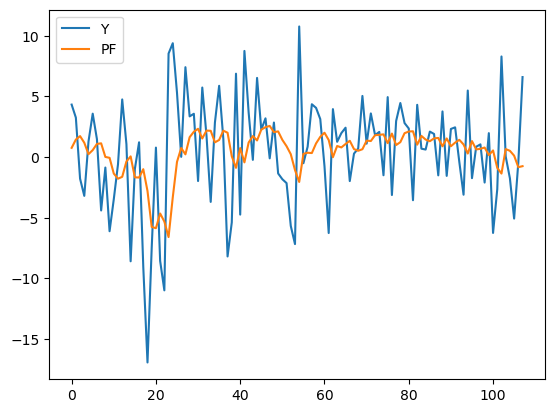

In [15]:
from matplotlib import pyplot as plt
plt.plot(observation[48:], label='Y')
plt.plot(np.mean(y, axis=1)[48:], label='PF')
plt.legend()
plt.show()